In [ ]:
import io
import re
import matplotlib.pyplot as plt
import string
import numpy as np
import pandas as pd
from utils import *

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental import preprocessing

In [54]:
# iterate through zip file of occ reports to construct a dataframe (may take a while)

#occ_df = read_word_doc_zip_as_df('occ-report-docs/occ-reports.zip')

In [55]:
#occ_df = occ_df[["Time", "Log", "BPD"]]
#occ_df['BPD'] = occ_df['BPD'].apply(lambda x: str(x).strip())

In [56]:
#csv = occ_df.to_csv('csv/occ-reports.csv', index=False)

In [57]:
#csv_to_dataset(csv_path, batch_size, label, num_epochs)

In [58]:
occ_df = pd.read_csv('csv/nadav-labeled-2.csv')
occ_df = occ_df[["Log", "Cat"]]

# first 100 rows are labeled
labeled_df = occ_df.iloc[:500,:]
unlabeled_df = occ_df.iloc[501:,:]

#labeled_df = labeled_df[labeled_df.Cat.apply(lambda x: x.isnumeric())]
labeled_df['Cat'] = labeled_df['Cat'].apply(lambda x: int(x))
labeled_df.head(5)

<ipython-input-58-2dd475f7fb39>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['Cat'] = labeled_df['Cat'].apply(lambda x: int(x))


,Log,Cat
0,"T385 released, 5 minutes late.",10
1,CAR COUNT\nA’s: 51 B’s: 329 C’s: 172 ...,10
2,Daily SCRAM / Spare Train Report: OCY: T337 Ho...,10
3,T229 late dispatching OHY due to FW scheduling...,7
4,"T229 verifies A78 [A1 & A2 tracks] cranked, cl...",6


In [59]:
# Save dataframes as csv files

labeled_df.to_csv('csv/labeled.csv', index=False)
unlabeled_df.to_csv('csv/unlabeled.csv', index=False)

In [60]:
# Convert csv to tf dataset

labeled_ds = csv_to_dataset('csv/labeled.csv', batch_size=1, label='Cat', num_epochs=1)
unlabeled_ds = csv_to_dataset('csv/unlabeled.csv', batch_size=1, label='Cat', num_epochs=1)

In [62]:
# Split labeled dataset into train and validation sets (planning on implementing k-fold cross validation)
labeled_ds = labeled_ds.shuffle(500)
train_ds = labeled_ds.take(400)
val_ds = labeled_ds.skip(400)

In [63]:
# Not really sure what this does but apparently it make the code run faster 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [64]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
    return input_data
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

In [65]:
# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 20

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x['Log'])
vectorize_layer.adapt(text_ds)

In [66]:
# hyperparameters
embedding_dim=5
hidden_layers=20

model = Sequential([
  vectorize_layer,                                         # Map strings to integer indices within the vocabulary
  Embedding(vocab_size, embedding_dim, name="embedding"),  # Maps integer indices (which stand for specific words) to dense vectors (their embeddings)
  GlobalAveragePooling1D(),                                # Average of the embedding values over sequence length
  Dense(hidden_layers, activation='relu'),
  Dense(hidden_layers, activation='relu'),
  Dense(14, activation="softmax")                          # Output layer
])

In [67]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [68]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [69]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[tensorboard_callback])

Epoch 1/30
400/400 [==============================] - 1s 2ms/step - loss: 2.1169 - accuracy: 0.4125 - val_loss: 1.6819 - val_accuracy: 0.4300
Epoch 2/30
400/400 [==============================] - 1s 2ms/step - loss: 1.6452 - accuracy: 0.4350 - val_loss: 1.4626 - val_accuracy: 0.4800
Epoch 3/30
400/400 [==============================] - 1s 2ms/step - loss: 1.3904 - accuracy: 0.5100 - val_loss: 1.2105 - val_accuracy: 0.5700
Epoch 4/30
400/400 [==============================] - 1s 2ms/step - loss: 1.1868 - accuracy: 0.5900 - val_loss: 1.0419 - val_accuracy: 0.6300
Epoch 5/30
400/400 [==============================] - 1s 2ms/step - loss: 1.0161 - accuracy: 0.6725 - val_loss: 0.8948 - val_accuracy: 0.7200
Epoch 6/30
400/400 [==============================] - 1s 2ms/step - loss: 0.8758 - accuracy: 0.7425 - val_loss: 0.7766 - val_accuracy: 0.7500
Epoch 7/30
400/400 [==============================] - 1s 2ms/step - loss: 0.7633 - accuracy: 0.7725 - val_loss: 0.6875 - val_accuracy: 0.7700
Epoch 

In [70]:
loss, accuracy = model.evaluate(train_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

400/400 [==============================] - 0s 1ms/step - loss: 0.0418 - accuracy: 0.9900
Loss:  0.041825227439403534
Accuracy:  0.9900000095367432


In [71]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

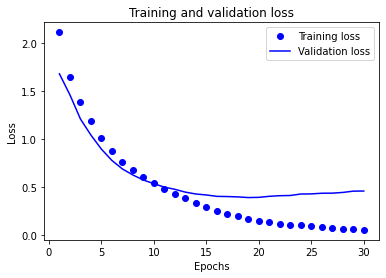

In [72]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

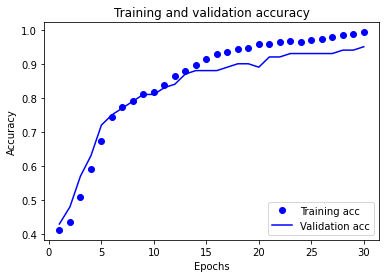

In [73]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [74]:
i = 1
for element in unlabeled_ds:
    print(element)
    print(np.argmax(model.predict(element), axis=1))
    i-=1
    if i == 0:
        break
    print()

(OrderedDict([('Log', <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'T223 moving ATO, the person was just sleeping and refused any assistance. Minimal delay.'],
      dtype=object)>)]), <tf.Tensor: shape=(1,), dtype=string, numpy=array([b''], dtype=object)>)
[12]


In [75]:
# Save word embeddings 
# view embedding @ http://projector.tensorflow.org/
# upload vectors.tsv and metadata.tsv

weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

save_embeddings(weights, vocab)

In [76]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [77]:
model = tf.keras.models.load_model('model')

In [78]:
class_legend = MLB_team = {
    0:"Misc",
    1:'Other BPD',
    2:'Homeless',
    3:'Medical',
    4:'Patron interference',
    5:"Vehicle failure",
    6:"Wayside equipment",
    7:"Software related failures",
    8:"Human Error",
    9:"Weather",
    10:"Info (no error)",
    11:"Delays",
    12:"Track obstruction",
    13:"Schedule maintenance"
}

In [79]:
for log in ["T221 late arrival to K30-2", 
            "DMZ1 cleared Cat B W/O's for the M55XL. Protections released.", 
            "T445 BPD hold K30-1 for a half naked man on the trail c346."
           ]:
    print(class_legend[np.argmax(model.predict([log]))])


Delays
Patron interference
Other BPD


In [80]:
labeled_df

,Log,Cat
0,"T385 released, 5 minutes late.",10
1,CAR COUNT\nA’s: 51 B’s: 329 C’s: 172 ...,10
2,Daily SCRAM / Spare Train Report: OCY: T337 Ho...,10
3,T229 late dispatching OHY due to FW scheduling...,7
4,"T229 verifies A78 [A1 & A2 tracks] cranked, cl...",6
...,...,...
495,"T235 no ATO doors at S20-2, 311.",5
496,"T455 released ATO, 8 minute delay.",11
497,"T455 released ATO, 8 minute delay.",11
498,"T455 released ATO, 8 minute delay.",11


In [81]:
labeled_df['Log'] = labeled_df['Log'].apply(lambda log: str(log))

<ipython-input-81-a4d23db6745c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['Log'] = labeled_df['Log'].apply(lambda log: str(log))


In [82]:
labeled_df['Pred'] = labeled_df['Log'].apply(lambda log: np.argmax(model.predict([log]), axis=1)[0])


<ipython-input-82-d8dd946d9a9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['Pred'] = labeled_df['Log'].apply(lambda log: np.argmax(model.predict([log]), axis=1)[0])


In [84]:
labeled_df[400:].head(50)

,Log,Cat,Pred
400,"T441 BOIP approaching R50-2, TO completing Aux...",7,7
401,"T441 approaching R50-2 stopped with a BOIP, tr...",7,8
402,"T227 no ATO doors at S20-2, 311.",5,5
403,T441 reports they are moving ATO after the AUX...,7,7
404,"T449 M20-2 door open, instructed to do a coupl...",7,5
405,"T441 9.3 R2 track stopped again with the BOIP,...",7,7
406,"T449 moving ATO, door open self cleared, 3 min...",11,11
407,"T517 no ATO doors at M90-1, 311.",5,5
408,"T441 ATO once again, now 6 late.",11,11
409,"T441 7.6 R2 track stopped again with the BOIP,...",7,12


In [ ]:
# :)